notebook_007_orbitpropa_iss_vis_ct

# ISS visibility in Cape Town in the evening of 26 August 2017

Pretty much the same thing as notebook_005_orbitpropa_sgp4_local_topo_visualization.ipynb, except that the observer is in Cape Town, South Africa

@author: Ashiv Dhondea

created on: 26.08.17

In [1]:
# Load the libraries required
# These two are mine
import AstroFunctions as AstFn
import UnbiasedConvertedMeasurements as UCM

import math
import numpy as np

# Libraries needed for time keeping and formatting
import datetime as dt
import pytz

# Importing what's needed for nice plots.
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Helvetica']})
rc('text', usetex=True)
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# Module for SGP4 orbit propagation
from sgp4.earth_gravity import wgs84
from sgp4.io import twoline2rv

The figure below shows a space object (SO) in orbit around the Earth.

The ECEF and SEZ frames are defined in the figure below. 

The label 'Rx' denotes the receiver in a radar system. Here it denotes the location of the ground station on the surface of the Earth.

The longitude $\lambda$ and geocentric latitude $\phi_\text{gc}$ define the location of a point on the surface of the WGS84 oblate spheroid.

The geocentric latitude $\phi_\text{gc}$ is calculated from the geodetic latitude $\phi_\text{gd}$ which is usually quoted online (Google Earth, heavens-above etc.)

In radar coordinates, aka spherical coordinates, the position of the SO with respect to the radar is expressed as $(\rho,\theta,\psi)$. The slant-range from the observer to the target is denoted by $\rho$ while the look angles, i.e., the elevation angle and azimuth angle are denoted by $\theta$ and $\psi$, respectively.

It is extremely important to take note of how these two angles are defined. Different authors in different fields employ different definitions for the look angles. The azimuth angle $\psi$ is measured from the positive $x$-axis to the positive $y$-axis in this project. Vallado (2013) defines his azimuth angle from the negative $x$-axis to the positive $y$-axis.

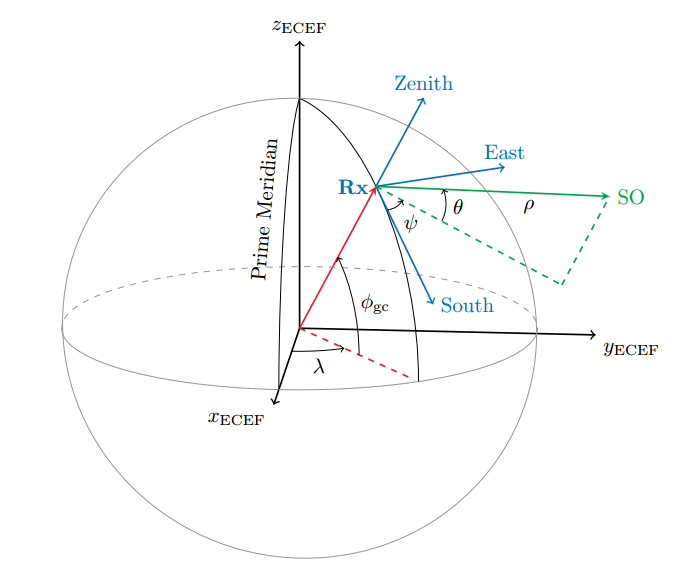

In [2]:
from IPython.display import Image
Image(filename='ashivorbit2017.png')
# Note that this image belongs to me. I have created it myself.

In [3]:
"""
http://heavens-above.com/SelectLocation.aspx?lat=-20.2973&lng=57.4967&loc=Vacoas-Phoenix&alt=431&tz=UCTm4
"""
# Location of observer [Cape Town, SA]
lat_station = -33.9585; # [deg]
lon_station =  18.4593; # [deg]
altitude_station = 129.e-3; # [km]
# More specifically, the ground station has been placed at Menzies' building.
ground_station='Cape Town'

In [4]:
## ISS (ZARYA)                        
tle_line1 = '1 25544U 98067A   17238.18406250  .00002219  00000-0  40664-4 0  9995';
tle_line2 = '2 25544  51.6399  49.3795 0004977 179.3457 159.4531 15.54203357 72636';
so_name = 'ISS (ZARYA)'
# Read TLE to extract Keplerians and epoch. 
a,e,i,BigOmega,omega,E,nu,epoch  = AstFn.fnTLEtoKeps(tle_line1,tle_line2);

# Create satellite object
satellite_obj = twoline2rv(tle_line1, tle_line2, wgs84);

line1 = (tle_line1);
line2 = (tle_line2);

In [5]:
# Figure out the TLE epoch 
year,dayy, hrs, mins, secs, millisecs = AstFn.fn_Calculate_Epoch_Time(epoch);
todays_date = AstFn.fn_epoch_date(year,dayy);
print "TLE epoch date is", todays_date
print "UTC time = ",hrs,"h",mins,"min",secs+millisecs,"s"
timestamp_tle_epoch = dt.datetime(year=todays_date.year,month=todays_date.month,day=todays_date.day,hour=hrs,minute=mins,second=secs,microsecond=int(millisecs),tzinfo= pytz.utc);


TLE epoch date is 2017-08-26
UTC time =  4 h 25 min 3.0 s


According to heavens-above.com, the ISS will be visible in Cape Town from 19:46:14 to 19:50:19 (local time).

The local time (SAST) is 2 hours ahead of UTC.
So the observation epoch is 17:46:14 to 17:50:19

In [6]:
# Find start and end of observation window.
# Find the time elapsed between the epoch of the TLE and the start and end of the observation window
observation_epoch= dt.datetime(year=todays_date.year,month=todays_date.month,day=26,hour=17,minute=50,second=19,microsecond=0,tzinfo= pytz.utc);
simulation_duration_dt_obj = observation_epoch - timestamp_tle_epoch;
simulation_duration_secs = simulation_duration_dt_obj.total_seconds();

start_observation_epoch = dt.datetime(year=todays_date.year,month=todays_date.month,day=26,hour=17,minute=46,second=14,microsecond=0,tzinfo= pytz.utc)
start_simulation_duration_dt_obj = start_observation_epoch - timestamp_tle_epoch;
start_simulation_duration_secs = start_simulation_duration_dt_obj.total_seconds()

In [7]:
# Declare time and state vector variables.
delta_t = 1; #[s]
print 'Propagation time step = %d' %delta_t, '[s]'
duration = simulation_duration_secs; #[s]
print 'Duration of simulation = %d' %duration, '[s]'
timevec = np.arange(0,duration+delta_t,delta_t,dtype=np.float64);
x_state_sgp4 = np.zeros([6,len(timevec)],dtype=np.float64);
xecef_sgp4 = np.zeros([3,len(timevec)],dtype=np.float64);
# Declare variables to store latitude and longitude values of the ground track
lat_sgp4 = np.zeros([len(timevec)],dtype=np.float64);
lon_sgp4 = np.zeros([len(timevec)],dtype=np.float64);

Propagation time step = 1 [s]
Duration of simulation = 48317 [s]


In [8]:
# Identify the indices corresponding to start and end of the observation window
obsv_window_start_index = int(start_simulation_duration_secs/delta_t)
obsv_window_end_index = len(timevec) - 1;
print 'observation window starts at index '
print obsv_window_start_index
print 'and ends at '
print obsv_window_end_index
obsv_window_duration = (obsv_window_end_index - obsv_window_start_index);# should be int, not float
print 'Duration of observation window in [min]'
print obsv_window_duration*delta_t/60
obsv_window_timestamps = [None]*(obsv_window_duration+1); # Initialize empty list to hold time stamps
print 'Number of data points in observation window: '
print len(obsv_window_timestamps)

observation window starts at index 
48072
and ends at 
48317
Duration of observation window in [min]
4
Number of data points in observation window: 
246


In [9]:
R_SEZ = np.zeros([3,len(timevec)],dtype=np.float64);
V_SEZ = np.zeros([3,len(timevec)],dtype=np.float64);
x_target = np.zeros([6,len(timevec)],dtype=np.float64); 
#  spherical measurements from the Rx
y_sph_rx = np.zeros([3,len(timevec)],dtype=np.float64);
theta_GMST = np.zeros([len(timevec)],dtype=np.float64); 

index = 0;
current_time = timevec[index];
hrs,mins,secs = AstFn.fnSeconds_To_Hours(current_time + (satellite_obj.epoch.hour*60*60) + (satellite_obj.epoch.minute*60)+ satellite_obj.epoch.second);
dys = satellite_obj.epoch.day + int(math.ceil(hrs/24));     
if hrs >= 24:
    hrs = hrs - 24*int(math.ceil(hrs/24)) ;
satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
x_state_sgp4[0:3,index] = np.asarray(satpos);
x_state_sgp4[3:6,index] = np.asarray(satvel);

theta_GMST[0] =  math.radians(AstFn.fn_Convert_Datetime_to_GMST(timestamp_tle_epoch));        
# Rotate ECI position vector by GMST angle to get ECEF position
theta_GMST[0] = AstFn.fnZeroTo2Pi(theta_GMST[0]);
xecef_sgp4[:,index] = AstFn.fnECItoECEF(x_state_sgp4[0:3,index],theta_GMST[index]);
lat_sgp4[index],lon_sgp4[index] = AstFn.fnCarts_to_LatLon(xecef_sgp4[:,index]);

for index in range(1,len(timevec)):
    # Find the current time
    current_time = timevec[index];
    hrs,mins,secs = AstFn.fnSeconds_To_Hours(current_time + (timestamp_tle_epoch.hour*60*60) + (timestamp_tle_epoch.minute*60)+ timestamp_tle_epoch.second);
    dys = timestamp_tle_epoch.day + int(math.ceil(hrs/24)); 
    if hrs >= 24:
        hrs = hrs - 24*int(math.ceil(hrs/24)) ;
        
    # SGP4 propagation
    satpos,satvel = satellite_obj.propagate(satellite_obj.epoch.year,satellite_obj.epoch.month,dys,hrs,mins,secs+(1e-6)*satellite_obj.epoch.microsecond);
    x_state_sgp4[0:3,index] = np.asarray(satpos);
    x_state_sgp4[3:6,index] = np.asarray(satvel);
    
    # From the epoch, find the GMST angle.
    tle_epoch_test = dt.datetime(year=timestamp_tle_epoch.year,month=timestamp_tle_epoch.month,day=int(dys),hour=int(hrs),minute=int(mins),second=int(secs),microsecond=0,tzinfo= pytz.utc);
    theta_GMST[index] =  math.radians(AstFn.fn_Convert_Datetime_to_GMST(tle_epoch_test));        
    # Rotate ECI position vector by GMST angle to get ECEF position
    theta_GMST[index] = AstFn.fnZeroTo2Pi(theta_GMST[index]);
    xecef_sgp4[:,index] = AstFn.fnECItoECEF(x_state_sgp4[0:3,index],theta_GMST[index]);
    lat_sgp4[index],lon_sgp4[index] = AstFn.fnCarts_to_LatLon(xecef_sgp4[:,index]);
    if index >= obsv_window_start_index:
        # We store away timestamps for the observation window
        current_time_iso = tle_epoch_test.isoformat() + 'Z'
        obsv_window_timestamps[index-obsv_window_start_index] =current_time_iso;
        
        # We find the position and velocity vector for the target in the local frame.
        # We then create the measurement vector consisting of range and look angles to the target.
        R_ECI = x_state_sgp4[0:3,index]; V_ECI = x_state_sgp4[3:6,index];  
        R_SEZ[:,index] = AstFn.fnRAZEL_Cartesian(math.radians(lat_station),math.radians(lon_station),altitude_station,R_ECI,theta_GMST[index]); 
        R_ECEF = AstFn.fnECItoECEF(R_ECI,theta_GMST[index]);
        V_SEZ[:,index] = AstFn.fnVel_ECI_to_SEZ(V_ECI,R_ECEF,math.radians(lat_station),math.radians(lon_station),theta_GMST[index]);
        x_target[:,index] = np.hstack((R_SEZ[:,index],V_SEZ[:,index])); # state vector in SEZ frame
        # Calculate range and angles for system modelling.
        y_sph_rx[:,index] = UCM.fnCalculate_Spherical(R_SEZ[:,index]); # slant-range and look angles wrt to Rx

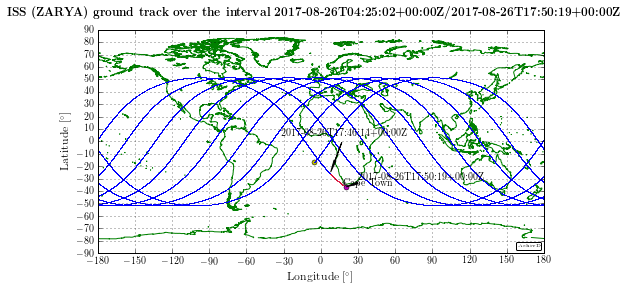

In [10]:
%matplotlib inline

title_string = str(timestamp_tle_epoch.isoformat())+ 'Z/'+str(obsv_window_timestamps[-1]);

coastline_data= np.loadtxt('Coastline.txt',skiprows=1)
w, h = plt.figaspect(0.5)
fig = plt.figure(figsize=(w,h))
ax = fig.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
params = {'legend.fontsize': 8,
    'legend.handlelength': 2}
plt.rcParams.update(params)

fig.suptitle(r"\textbf{%s ground track over the interval %s}" %(so_name,title_string),fontsize=12)
plt.plot(coastline_data[:,0],coastline_data[:,1],'g');
ax.set_xlabel(r'Longitude $[\mathrm{^\circ}]$',fontsize=12)
ax.set_ylabel(r'Latitude $[\mathrm{^\circ}]$',fontsize=12)
plt.xlim(-180,180);
plt.ylim(-90,90);
plt.yticks([-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90]);
plt.xticks([-180,-150,-120,-90,-60,-30,0,30,60,90,120,150,180]);
plt.plot(math.degrees(lon_sgp4[0]),math.degrees(lat_sgp4[0]),'yo',markersize=5,label=timestamp_tle_epoch.isoformat() + 'Z');
for index in range(1,obsv_window_start_index-1):
    plt.plot(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index]),'b.',markersize=1);

plt.annotate(r'%s' %obsv_window_timestamps[0], xy=(math.degrees(lon_sgp4[index+1]),math.degrees(lat_sgp4[index+1])),  xycoords='data',
            xytext=(math.degrees(lon_sgp4[index+1])-40,math.degrees(lat_sgp4[index+1])+30),
            arrowprops=dict(facecolor='black',shrink=0.05,width=0.1,headwidth=2))

for index in range(obsv_window_start_index,obsv_window_end_index+1):
    plt.plot(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index]),color='crimson',marker='.',markersize=1);

plt.plot(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index]),'mo',markersize=5,label=current_time_iso);

plt.annotate(r'%s' %obsv_window_timestamps[obsv_window_duration], xy=(math.degrees(lon_sgp4[index]),math.degrees(lat_sgp4[index])),  xycoords='data',
            xytext=(math.degrees(lon_sgp4[index])+10,math.degrees(lat_sgp4[index])+5),
            arrowprops=dict(facecolor='black', shrink=0.05,width=0.1,headwidth=2)
            )

ax.grid(True);
plt.plot(lon_station,lat_station,marker='.',color='gray'); # station lat lon
ax.annotate(r'%s' %ground_station, (18, -36));

at = AnchoredText("AshivD",prop=dict(size=5), frameon=True,loc=4)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at)
fig.savefig('notebook_007_orbitpropa_iss_vis_ct_groundtrack.pdf',format='pdf',bbox_inches='tight',pad_inches=0.01,dpi=100);

The ISS will appear in the sky in the North-West of Cape Town.

Radar people usually only deal with targets moving in a local frame. This is where they do their target motion analysis, radar geometry analysis, radar system design and whatnot.

For a space object (SO) problem, we have to transform the scenario into the local/topocentric frame, which is shown below.

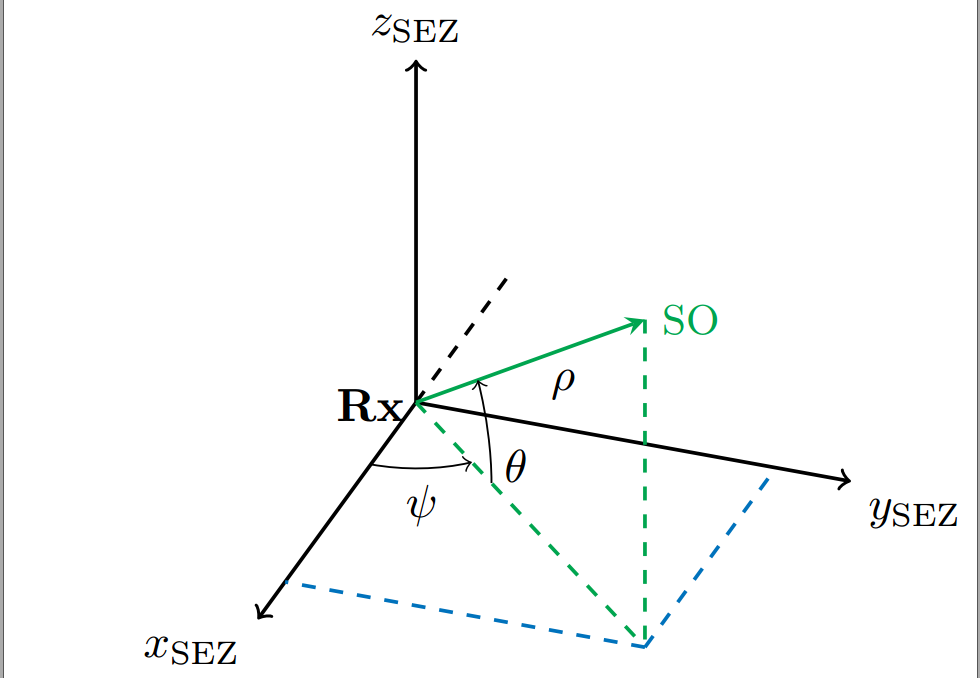

In [11]:
from IPython.display import Image
Image(filename='site_geometry_ashivd.png') 

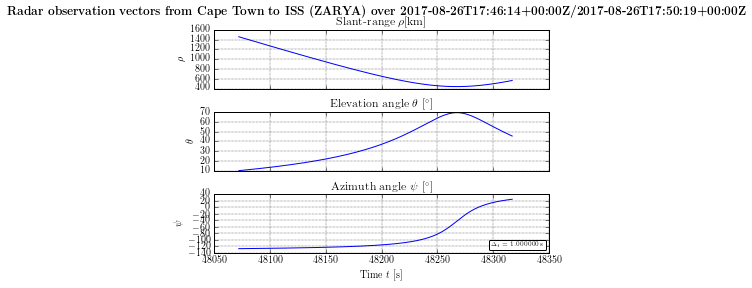

In [12]:
title_string_obsv = str(obsv_window_timestamps[0])+'/'+str(obsv_window_timestamps[-1]);

f, axarr = plt.subplots(3,sharex=True);
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
f.suptitle(r"\textbf{Radar observation vectors from %s to %s over %s}" %(ground_station,so_name,title_string_obsv),fontsize=12)
axarr[0].plot(timevec[obsv_window_start_index:obsv_window_end_index+1],y_sph_rx[0,obsv_window_start_index:obsv_window_end_index+1])
axarr[0].set_ylabel(r'$\rho$');
axarr[0].set_title(r'Slant-range $\rho [\mathrm{km}]$')
axarr[1].plot(timevec[obsv_window_start_index:obsv_window_end_index+1],np.degrees(y_sph_rx[1,obsv_window_start_index:obsv_window_end_index+1]))
axarr[1].set_title(r'Elevation angle $\theta~[\mathrm{^\circ}]$')
axarr[1].set_ylabel(r'$\theta$');

axarr[2].plot(timevec[obsv_window_start_index:obsv_window_end_index+1],np.degrees(y_sph_rx[2,obsv_window_start_index:obsv_window_end_index+1]))
axarr[2].set_title(r'Azimuth angle $\psi~[\mathrm{^\circ}]$')
axarr[2].set_ylabel(r'$ \psi$');
axarr[2].set_xlabel(r'Time $t~[\mathrm{s}$]');

axarr[0].grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')
axarr[1].grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')
axarr[2].grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')

at = AnchoredText(r"$\Delta_t = %f ~\mathrm{s}$" %delta_t,prop=dict(size=6), frameon=True,loc=4)
at.patch.set_boxstyle("round,pad=0.05,rounding_size=0.2")
axarr[2].add_artist(at)
# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axarr[0:2]], visible=False)
plt.subplots_adjust(hspace=0.4)
f.savefig('notebook_007_orbitpropa_iss_vis_ct_radarvec.pdf',bbox_inches='tight',pad_inches=0.05,dpi=100)  

The top plot shows the evolution of the slant-range to the target, $\rho$, over time. The middle plot shows that the elevation angle is about $10^\circ$ above the horizon at the beginning of the observation window. The target disappears at about $45^\circ$ above the horizon at the end of the observation window.

The target's azimuth angle changes from about $-125^\circ$ to $25^\circ$.

The elevation angle values closely match the ones found on the [heavens-above page](http://heavens-above.com/PassSummary.aspx?satid=25544&lat=-33.9585&lng=18.4593&loc=Cape+Town&alt=129&tz=SAST).

According to the azimuth angle defined in the previous figures, NW means an azimuth angle of $-135^\circ$ & SSE means $22.5^\circ$. Our values are slightly different (but in the same ballpark). Obviously, the Heavens-Above page is mainly intended for laypeople and as such, does not state the azimuth direction accurately.

Here's a screenshot

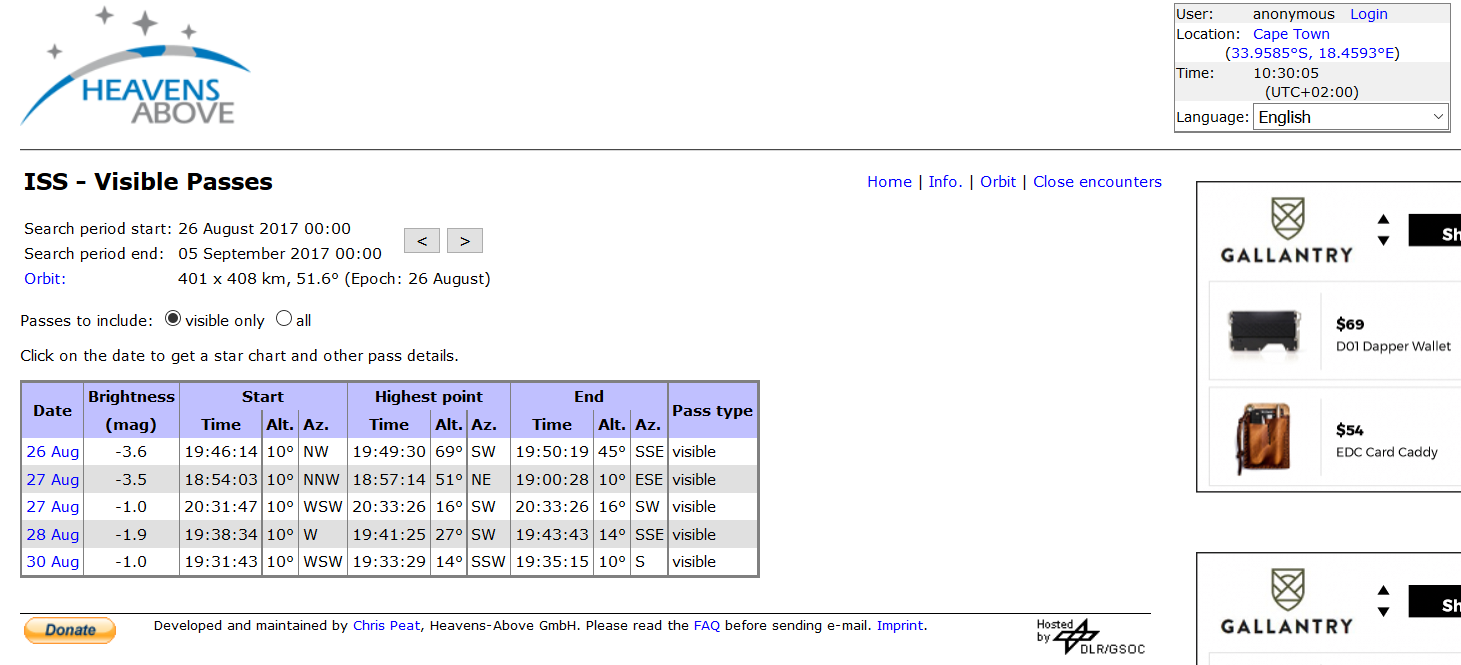

In [13]:
from IPython.display import Image
Image(filename='heavens_above_iss_passage_ct.png')

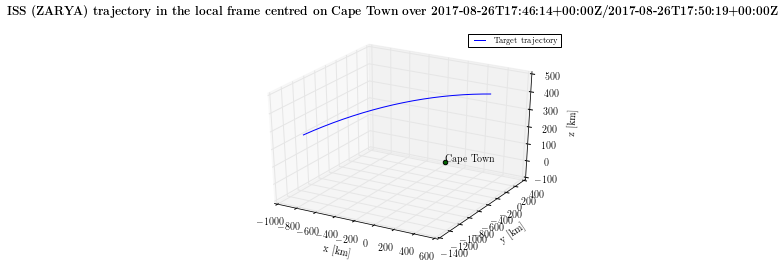

In [14]:
fig = plt.figure(3);
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
plt.rc('font',family='helvetica');
params = {'legend.fontsize': 8,
    'legend.handlelength': 2}
plt.rcParams.update(params);
ax = fig.gca(projection='3d');
plt.hold(True)
fig.suptitle(r"\textbf{%s trajectory in the local frame centred on %s over %s}" %(so_name,ground_station,title_string_obsv),fontsize=12)

ax.plot(R_SEZ[0,obsv_window_start_index:obsv_window_end_index+1],R_SEZ[1,obsv_window_start_index:obsv_window_end_index+1],R_SEZ[2,obsv_window_start_index:obsv_window_end_index+1],label=r'Target trajectory');

ax.scatter(0,0,0,c='darkgreen',marker='o');
ax.text(0,0,0,r'%s' %ground_station,color='k')

ax.legend();
ax.set_xlabel(r'x [$\mathrm{km}$]')
ax.set_ylabel(r'y [$\mathrm{km}$]')
ax.set_zlabel(r'z [$\mathrm{km}$]')
fig.savefig('notebook_007_orbitpropa_iss_vis_ct_local_topo_visualization_SEZtrack.pdf',format='pdf',bbox_inches='tight',pad_inches=0.08,dpi=100);

In [15]:
## right ascension and declination to target
ra = np.zeros([len(timevec)],dtype=np.float64);
dec = np.zeros([len(timevec)],dtype=np.float64);

for index in range(obsv_window_start_index,obsv_window_end_index+1):
    valladoazim = math.pi - y_sph_rx[2,index];
    RA, DEC = AstFn.fnConvert_AZEL_to_Topo_RADEC(y_sph_rx[1,index],valladoazim,math.radians(lat_station),math.radians(lon_station),theta_GMST[index]);
    ra[index] =  math.degrees(RA);
    dec[index] =  math.degrees(DEC);

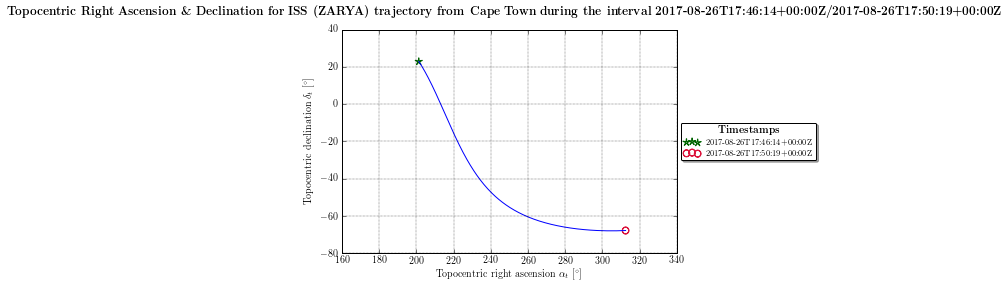

In [16]:
fig = plt.figure(4);
ax = fig.gca()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.axis('equal')
fig.suptitle(r"\textbf{Topocentric Right Ascension \& Declination for %s trajectory from %s during the interval %s}" %(so_name,ground_station,title_string_obsv) ,fontsize=12);
plt.plot(ra[obsv_window_start_index:obsv_window_end_index+1],dec[obsv_window_start_index:obsv_window_end_index+1],color='blue');

plt.scatter(ra[obsv_window_start_index],dec[obsv_window_start_index],s=50,marker=r"$\star$",facecolors='none', edgecolors='darkgreen',label=r"%s" %str(obsv_window_timestamps[0]));
plt.scatter(ra[obsv_window_end_index],dec[obsv_window_end_index],s=50,marker=r"$\bigcirc$",facecolors='none',edgecolors='crimson',label=r"%s" %str(obsv_window_timestamps[-1]));

ax.set_xlabel(r'Topocentric right ascension $\alpha_{t}~[\mathrm{^\circ}]$')
ax.set_ylabel(r'Topocentric declination $ \delta_{t}~[\mathrm{^\circ}]$');

plt.legend(loc='center left',title=r"\textbf{Timestamps}",bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True)

plt.grid(True,which='both',linestyle=(0,[0.7,0.7]),lw=0.4,color='black')
fig.savefig('notebook_007_orbitpropa_iss_vis_ct_radec.pdf',bbox_inches='tight',pad_inches=0.11,dpi=100)

The figure above is a plot of the topocentric right ascension and declination profile of the target passage.

If you stand outside at the given location and at the given time, you will see the ISS moving along this path in the sky. 

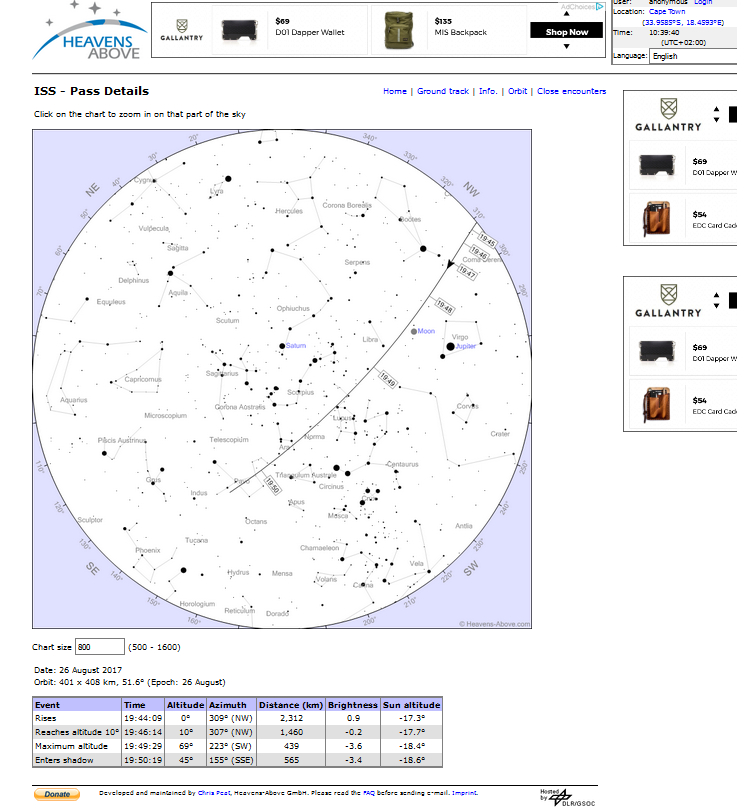

In [17]:
from IPython.display import Image
Image(filename='heavens_above_iss_passage_ct_sky.png')

This screenshot from Heavens-Above shows the sky during the ISS passage. You will notice that the Heavens Above plot has been flipped left to right. 

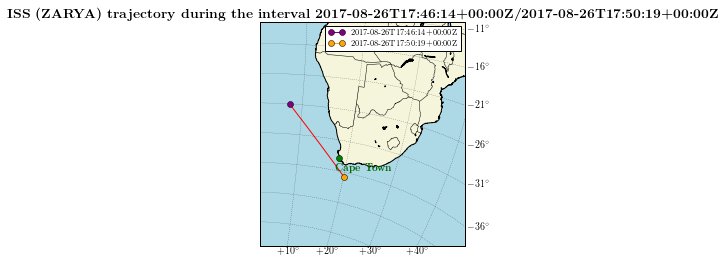

In [18]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(5);
plt.rc('text', usetex=True)
plt.rc('font', family='serif');
map = Basemap(llcrnrlon=3.0,llcrnrlat=-50.0,urcrnrlon=37.,urcrnrlat=-10.,resolution='i', projection='cass', lat_0 = 0.0, lon_0 = 0.0)
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary(fill_color='lightblue')
map.fillcontinents(color='beige',lake_color='lightblue')
lon =np.rad2deg(lon_sgp4);
lat = np.rad2deg(lat_sgp4);
x,y = map(lon[obsv_window_start_index:obsv_window_end_index+1], lat[obsv_window_start_index:obsv_window_end_index+1])
map.plot(x, y, color="red", latlon=False,linewidth=1)
x,y = map(lon_station,lat_station)
map.plot(x,y,marker='o',color='green'); 

x2,y2 = map(18,-36)
plt.annotate(r"\textbf{%s}" %ground_station, xy=(x2, y2),color='darkgreen')

parallels = np.arange(-81.,0.,5.)
# labels = [left,right,top,bottom]
map.drawparallels(parallels,labels=[False,True,False,False],labelstyle='+/-',linewidth=0.2)
meridians = np.arange(10.,351.,10.)
map.drawmeridians(meridians,labels=[True,False,False,True],labelstyle='+/-',linewidth=0.2)
plt.title(r'\textbf{%s trajectory during the interval %s}' %(so_name,title_string_obsv), fontsize=14)
x_start,y_start = map(lon[obsv_window_start_index],lat[obsv_window_start_index])
x_end,y_end = map(lon[obsv_window_end_index],lat[obsv_window_end_index])
map.plot(x_start,y_start,color="purple",marker='o',label=r"%s" %str(obsv_window_timestamps[0]))
map.plot(x_end,y_end,color="orange",marker='o',label=r"%s" %str(obsv_window_timestamps[-1]))
plt.legend(loc=1)
fig.savefig('notebook_007_orbitpropa_iss_vis_ct_map.pdf',bbox_inches='tight',pad_inches=0.05,dpi=100) 

The software can also calculate the instantaneous Doppler shift arising due to the radial velocity of the target with respect to the ground station.